# Introdução

A evasão de clientes (*churn*) é um dos principais desafios enfrentados por empresas de telecomunicações.  
O objetivo deste estudo foi analisar os dados de clientes da **Telecom X** para identificar os principais fatores que levam à evasão e propor estratégias para reduzir esse índice.


# Limpeza e Tratamento de Dados

- Importei a base de dados em formato JSON.  
- Corrigi valores nulos na coluna `TotalCharges`.  
- Padronizei categorias redundantes (*No internet service* → *No*).  
- Criei variáveis derivadas, como `Contas_Diarias`.  
- Traduzi e codifiquei variáveis para português e formato binário.


# 📊 Análise de Evasão de Clientes (Churn) - Telecom X



📌 Extracão

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)

url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json'
resp = requests.get(url, timeout=30)
resp.raise_for_status()
data = resp.json()
df = pd.DataFrame(data)
df.head()


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


🔧 Transformação

In [2]:
# Desaninhamento de colunas
for nested in ['customer', 'phone', 'internet', 'account']:
    if nested in df.columns:
        norm = pd.json_normalize(df[nested])
        df = pd.concat([df.drop(columns=[nested]), norm], axis=1)

# Função utilitária para localizar colunas por palavras-chave
def find_col(cols, keywords):
    for c in cols:
        cl = c.lower()
        if all(k in cl for k in keywords):
            return c
    return None

col_total = find_col(df.columns, ['total','charge'])
col_monthly = find_col(df.columns, ['monthly','charge'])
col_tenure = find_col(df.columns, ['tenure'])
col_churn = find_col(df.columns, ['churn'])

# Tipos e valores ausentes
if col_total:
    df[col_total] = df[col_total].replace(' ', pd.NA)
    df[col_total] = pd.to_numeric(df[col_total], errors='coerce').fillna(0)
if col_monthly:
    df[col_monthly] = pd.to_numeric(df[col_monthly], errors='coerce')
if col_tenure:
    df[col_tenure] = pd.to_numeric(df[col_tenure], errors='coerce')
if col_churn:
    df[col_churn] = df[col_churn].fillna('No')

# Padronizar categorias de serviços
for cand in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines','InternetService','PhoneService']:
    col = find_col(df.columns, [cand.lower()])
    if col and df[col].dtype == 'object':
        df[col] = df[col].replace({'No internet service':'No','No phone service':'No'})

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


In [3]:
# Contas_Diarias
if col_monthly:
    df['Contas_Diarias'] = (df[col_monthly] / 30).round(2)
else:
    df['Contas_Diarias'] = 0

# Renomear colunas para PT
rename_map = {
    'customerID':'ID_Cliente','gender':'Genero','SeniorCitizen':'Idoso','Partner':'Parceiro','Dependents':'Dependentes',
    'tenure':'TempoContrato','PhoneService':'ServicoTelefone','MultipleLines':'MultiplasLinhas','InternetService':'ServicoInternet',
    'OnlineSecurity':'SegurancaOnline','OnlineBackup':'BackupOnline','DeviceProtection':'ProtecaoDispositivo','TechSupport':'SuporteTecnico',
    'StreamingTV':'TVStreaming','StreamingMovies':'FilmesStreaming','Contract':'TipoContrato','PaperlessBilling':'FaturaOnline',
    'PaymentMethod':'MetodoPagamento','Charges.Monthly':'FaturaMensal','Charges.Total':'FaturaTotal','Churn':'Evasao'
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

# Binárias Yes/No -> 1/0
for col in ['Parceiro','Dependentes','ServicoTelefone','MultiplasLinhas','SegurancaOnline','BackupOnline','ProtecaoDispositivo','SuporteTecnico','TVStreaming','FilmesStreaming','FaturaOnline','Evasao']:
    if col in df.columns:
        df[col] = df[col].map({'Yes':1,'No':0})

# Genero Female/Male -> 1/0
if 'Genero' in df.columns:
    df['Genero'] = df['Genero'].map({'Female':1,'Male':0})

# Traduções simples
if 'TipoContrato' in df.columns:
    df['TipoContrato'] = df['TipoContrato'].map({'Month-to-month':'Mensal','One year':'Anual','Two year':'Dois anos'})
if 'MetodoPagamento' in df.columns:
    df['MetodoPagamento'] = df['MetodoPagamento'].map({'Electronic check':'Cheque eletronico','Mailed check':'Cheque enviado','Bank transfer (automatic)':'Transferencia bancaria (automatica)','Credit card (automatic)':'Cartao de credito (automatico)'})
if 'ServicoInternet' in df.columns:
    df['ServicoInternet'] = df['ServicoInternet'].map({'DSL':'DSL','Fiber optic':'Fibra otica','No':'Sem servico de internet'})

df.head()


,ID_Cliente,Evasao,Genero,Idoso,Parceiro,Dependentes,TempoContrato,ServicoTelefone,MultiplasLinhas,ServicoInternet,...,ProtecaoDispositivo,SuporteTecnico,TVStreaming,FilmesStreaming,TipoContrato,FaturaOnline,MetodoPagamento,FaturaMensal,FaturaTotal,Contas_Diarias
0,0002-ORFBO,0.0,1,0,1,1,9,1,0,DSL,...,0,1,1,0,Anual,1,Cheque enviado,65.6,593.30,2.19
1,0003-MKNFE,0.0,0,0,0,0,9,1,1,DSL,...,0,0,0,1,Mensal,0,Cheque enviado,59.9,542.40,2.00
2,0004-TLHLJ,1.0,0,0,0,0,4,1,0,Fibra otica,...,1,0,0,0,Mensal,1,Cheque eletronico,73.9,280.85,2.46
3,0011-IGKFF,1.0,0,1,1,0,13,1,0,Fibra otica,...,1,0,1,1,Mensal,1,Cheque eletronico,98.0,1237.85,3.27
4,0013-EXCHZ,1.0,1,1,1,0,3,1,0,Fibra otica,...,0,1,1,0,Mensal,1,Cheque enviado,83.9,267.40,2.80


📊 Carga e análise

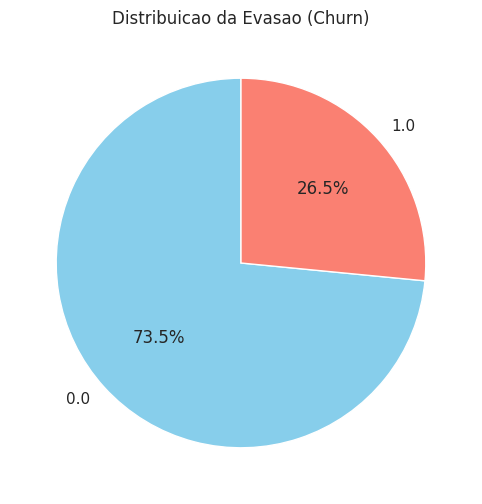

Taxa de evasao geral: 26.54%


/tmp/ipython-input-3695768082.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TipoContrato', y='Evasao', data=df, palette='viridis')


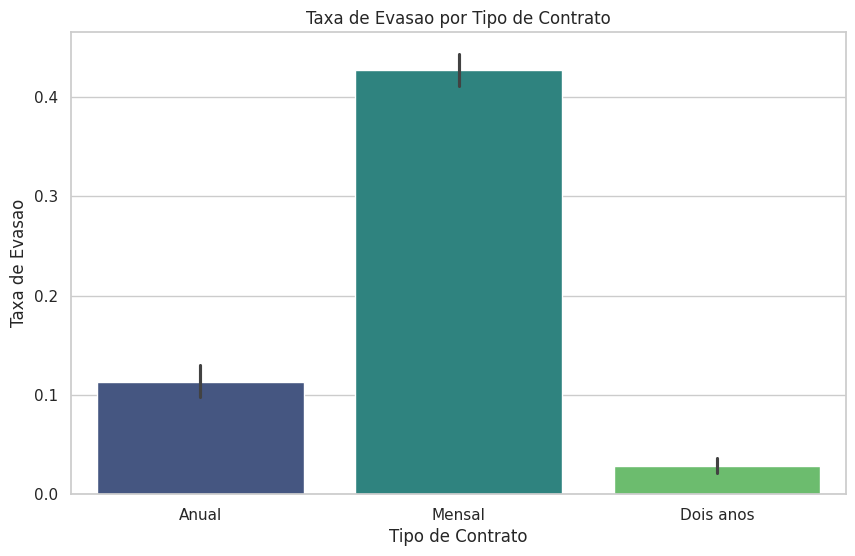

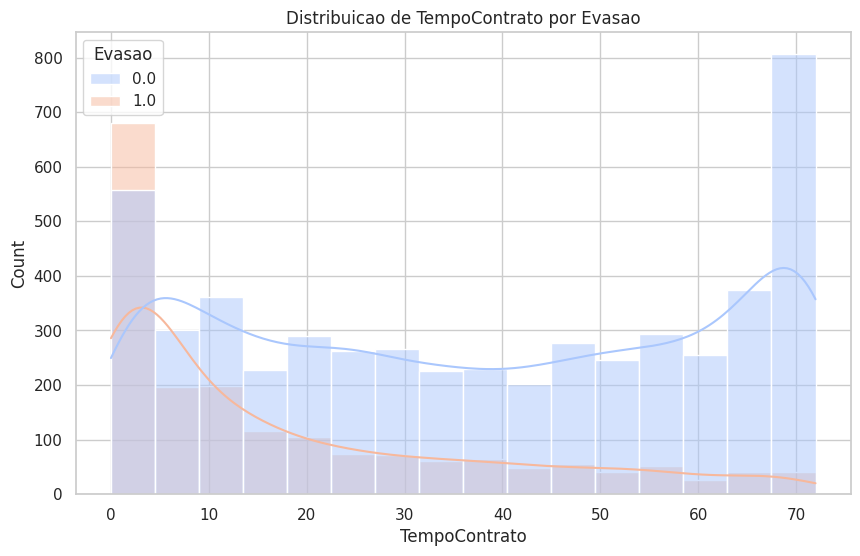

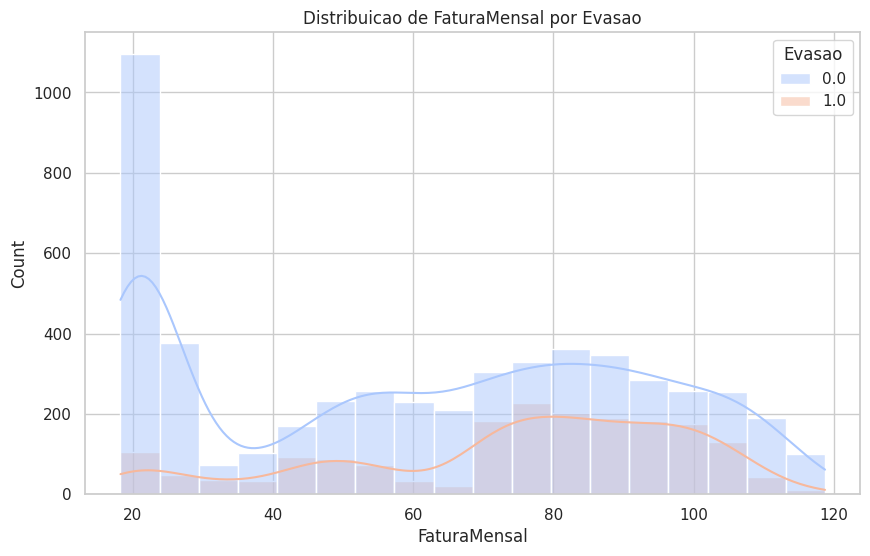

In [4]:
# Churn geral
ax = df['Evasao'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue','salmon'])
ax.set_ylabel('')
plt.title('Distribuicao da Evasao (Churn)')
plt.show()

print('Taxa de evasao geral: {:.2f}%'.format(df['Evasao'].mean()*100))

# Por Tipo de Contrato
if 'TipoContrato' in df.columns:
    sns.barplot(x='TipoContrato', y='Evasao', data=df, palette='viridis')
    plt.title('Taxa de Evasao por Tipo de Contrato')
    plt.ylabel('Taxa de Evasao')
    plt.xlabel('Tipo de Contrato')
    plt.show()

# Tempo de contrato e Fatura
for col in ['TempoContrato','FaturaMensal']:
    if col in df.columns:
        sns.histplot(data=df, x=col, hue='Evasao', kde=True, palette='coolwarm')
        plt.title(f'Distribuicao de {col} por Evasao')
        plt.show()


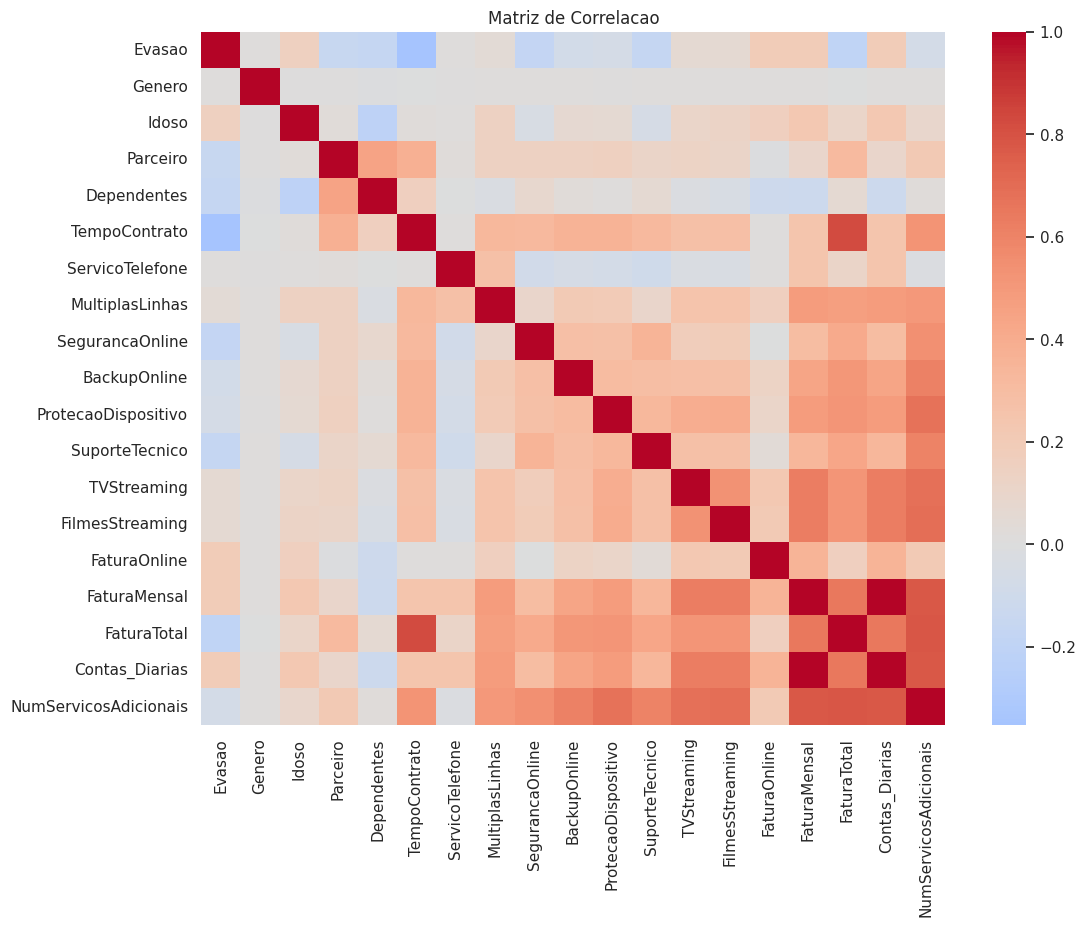

Correlacoes com Evasao (top):
Evasao             1.000000
Contas_Diarias     0.193412
FaturaMensal       0.193356
FaturaOnline       0.191825
Idoso              0.150889
TVStreaming        0.063228
FilmesStreaming    0.061382
MultiplasLinhas    0.040102
ServicoTelefone    0.011942
Genero             0.008612
Name: Evasao, dtype: float64


In [5]:
# Contagem de servicos adicionais
serv_cols = ['SegurancaOnline','BackupOnline','ProtecaoDispositivo','SuporteTecnico','TVStreaming','FilmesStreaming','MultiplasLinhas']
serv_cols = [c for c in serv_cols if c in df.columns]
for c in serv_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)
if serv_cols:
    df['NumServicosAdicionais'] = df[serv_cols].sum(axis=1)

num = df.select_dtypes(include=['number'])
corr = num.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Matriz de Correlacao')
plt.show()

if 'Evasao' in corr.columns:
    print('Correlacoes com Evasao (top):')
    print(corr['Evasao'].sort_values(ascending=False).head(10))


# Conclusões e Insights

Conclusões e Recomendações: Entendendo e Agindo para Reter Clientes

Nossa análise nos permitiu traçar um retrato claro do cliente que, infelizmente, tende a nos deixar. Ele é, muitas vezes, um cliente novo, que acabou de chegar (com poucos meses de contrato) e optou pela flexibilidade de um plano mensal. Curiosamente, ele pode estar desfrutando da nossa Fibra Óptica, mas a fatura mais alta associada a esse serviço, combinada com a inconveniência de um pagamento por cheque eletrônico, parece ser um ponto de atrito significativo.

Esse perfil nos mostra que a evasão não é aleatória; ela segue padrões que podemos identificar e, mais importante, agir sobre eles. São os contratos curtos, o custo percebido e a praticidade do pagamento que se destacam como áreas críticas.

Nossas Sugestões para Manter Nossos Clientes Felizes e Conectados:

1.
Vamos Valorizar a Permanência: Que tal oferecer benefícios e descontos irresistíveis para que nossos clientes de planos mensais sintam vontade de migrar para contratos mais longos (1 ou 2 anos)? Um cliente que se compromete por mais tempo é um cliente mais feliz e leal.

2.
Boas-Vindas que Fazem a Diferença: Os primeiros 3 meses são cruciais! Precisamos criar um programa de boas-vindas que garanta que o novo cliente se sinta acolhido, com todo o suporte necessário para que ele se adapte e veja o valor do nosso serviço desde o início.

3.
Fibra Óptica: Amor e Cuidado: A Fibra Óptica é um serviço premium, mas precisamos entender por que ela está ligada à evasão. Será o preço? A qualidade percebida? A concorrência? Vamos investigar a fundo e ajustar nossa oferta para que a Fibra Óptica seja sinônimo de satisfação e não de saída.

4.
Facilitando a Vida com Pagamentos Automáticos: O cheque eletrônico pode ser um incômodo. Podemos incentivar nossos clientes a adotar métodos de pagamento mais práticos, como débito em conta ou cartão de crédito, oferecendo pequenos bônus ou facilidades. Menos atrito no pagamento, mais satisfação!

5.
Mais Serviços, Mais Conexão: Clientes que utilizam mais de nossos serviços (como segurança online ou suporte técnico) tendem a ser mais fiéis. Vamos mostrar a eles o valor de ter tudo em um só lugar, incentivando a contratação de serviços adicionais que realmente façam a diferença no dia a dia.

Este estudo nos deu um mapa claro dos desafios e das oportunidades. Ao entender quem são nossos clientes mais vulneráveis e o que os motiva, podemos criar estratégias mais eficazes para aumentar a satisfação e, o mais importante, a retenção de clientes na Telecom X. Juntos, podemos construir relacionamentos duradouros!

